---
title: 'Lab03: Digit Recognition with Clustering'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: November 9, 2023
jupyter: python3
---

## Business Understanding

The data we are working with is part of the Modified National Institute of Standards and Technology (MNIST) digit recognition dataset for computer vision. The version we are using for this project is available from on [Kaggle](https://www.kaggle.com/competitions/digit-recognizer/overview).

The MNIST dataset contains a large collection of 28x28 pixel grayscale images of handwritten digits (0 through 9). This dataset is very commonly used in machine learning, and the objective is to correctly classify the digit in each image. Identifying handwritten digits is a common problem in many business use cases; a classifier could be used to automatically read addresses on envelopes, to read handwritten numbers on bank checks for mobile deposit, or to help grade tests in an educational setting.

For this project, we set out to explore the MNIST dataset using clustering techniques. Labels are available for this data, which makes it a good candidate for many other machine learning techniques. For example, the viability of Neural Networks for classifying digits has bee well documented. In practice, labelling tens of thousands of handwritten digits may time and cost prohibitive. We believe that clustering has the potential to identify groups of similar digits, which could be more easily and efficiently labelled. This would allow generalization of handwriting recognition outside of digits, and even the English language. Labelling in this way could then serve as a preprocessing step for training more complex models. 

To evaluate our clustering analysis we will primarily use accuracy after manually labelling the clusters. Neural Networks regularly achieve accuracies of more than 99% on this dataset [@MNIST]. We do not expect to achieve this level of accuracy, but we do expect to be able to identify clusters of digits with similar characteristics. The clusters will also be evaluated for separation in order to judge the feasibility of using them as a preprocessing step for other machine learning techniques.

## Data Understanding 1


Describe data here

In [84]:
import pandas as pd

# Choose File
# RawTrain = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/train.csv"
# RawTest = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/test.csv"
RawTrain = "data/train.csv"
RawTest = "data/test.csv"

# Read the CSV file
train = pd.read_csv(RawTrain)
test = pd.read_csv(RawTest)

# Get info on the train dataset
print(train.info())

# Get info on the test dataset
print(test.info())

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


Verify that data meets expectations

First we will check whether there is any missing values in the dataset. If so, we will visualize where they are and how we will address them.

In [85]:
# Check whether train or test have any missing values:
print(train.isnull().any().describe())
print(test.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


There are no missing values in the dataset.

In [86]:
# Not Needed:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Heatmap for training data
# plt.figure(figsize=(12, 6))
# sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Training Data')
# plt.show()

# # Heatmap for test data
# plt.figure(figsize=(12, 6))
# sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Test Data')
# plt.show()


Next we will check if there are any duplicated records in the datasets:

In [87]:
# Check for duplicate rows
duplicates = train[train.duplicated()]
print(duplicates.info())

duplicates = test[test.duplicated()]
print(duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 0.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 0.0 bytes
None


There are now duplicate rows in either dataset.

Next we will check for 'outliers'. Since the data is pixel values, we will check for values that are outside the range of 0 to 255. We will also check for unusual images by looking at the z-score of the sum of pixel values for each image. Since they are handwritten digits, we expect that the sum of pixel values will be similar for each image. Images outside of 3 standard deviations will be investigated further and may represent unusual images (e.g. images that are not digits, have colors reversed, etc.).

In [88]:
# Check whether any values are outside the range of 0 to 255:
print('Train records with value > 255:', train[train > 255].any().sum())
print('Train records with value < 0:', train[train < 0].any().sum())

print('Test records with value > 255:', test[test > 255].any().sum())
print('Test records with value < 0:', test[test < 0].any().sum())

Train records with value > 255: 0
Train records with value < 0: 0
Test records with value > 255: 0
Test records with value < 0: 0


There are no images with pixel values outside of the range of 0 to 255.

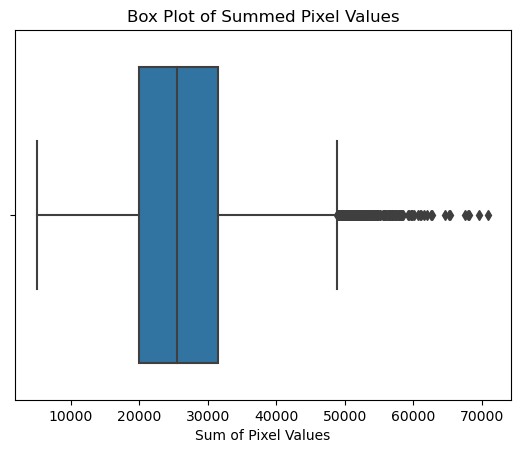

count      140.000000
mean     56014.321429
std       3808.971383
min      52092.000000
25%      53148.250000
50%      54790.000000
75%      57342.250000
max      70934.000000
dtype: float64


In [89]:
import seaborn as sns
from scipy import stats

# Calculate Z-scores for the sum of pixel values:
pixel_sum = test.iloc[1:, :].sum(axis=1)
z_scores = stats.zscore(pixel_sum)
outliers = pixel_sum[(z_scores > 3) | (z_scores < -3)]

# Plot the distribution of pixel sums:
sns.boxplot(x=pixel_sum)
plt.title('Box Plot of Summed Pixel Values')
plt.xlabel('Sum of Pixel Values')
plt.show()

print(outliers.describe())

There are 140 records with a z-score greater than 3. We will view random images from this set to see if they are unusual:

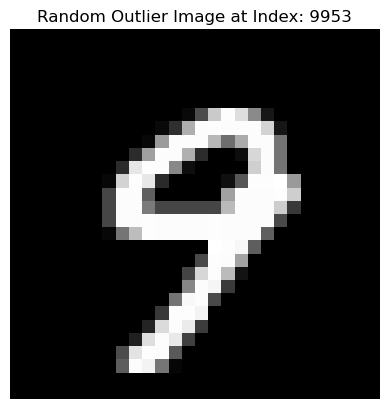

In [90]:
import matplotlib.pyplot as plt
import random

# Select a random index from the outliers
outlier_indexes = outliers.index
random_outlier_index = random.choice(outlier_indexes)

# Take the image data at the random index and reshape
image_data = train.iloc[random_outlier_index, 1:].values
image_matrix = image_data.reshape(28, 28)

# Display the image
plt.imshow(image_matrix, cmap='gray')
plt.title(f'Random Outlier Image at Index: {random_outlier_index}')
plt.axis('off')  # Turn off axis numbers
plt.show()

# Adopted from GPT-4

The outliers all appear to be handwritten digits. There are some with especially broad strokes. Many appear to be digits with more complexity (8,3,5 for example). We will not remove these outliers.

## Data Understanding 2

Visualize counts, view some random images.

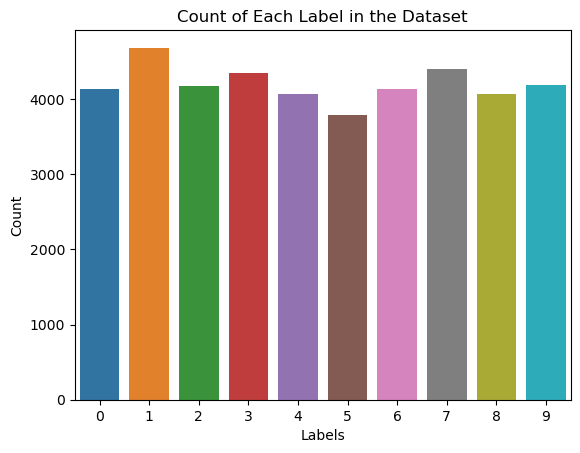

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot of digits
sns.countplot(x='label', data=train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label in the Dataset')

plt.show()


The digits in the training set appear uniformly distributed. Each label has approximately 4,000 samples or 10% of the dataset.

Here are some random images from the training set:

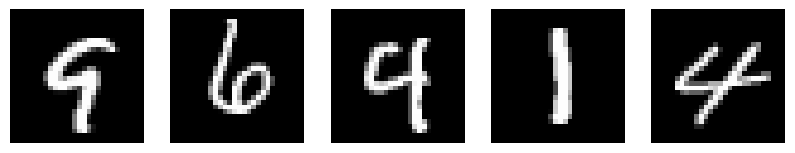

In [92]:
import numpy as np

# Display five random images from the training set:
def display_random_images(df, num_images):
    # Generate random indexes
    random_indexes = np.random.randint(0, len(df), num_images)

    # Retrieve random images by these indexes
    random_images = df.iloc[random_indexes, 1:].values

    # Reshape the random images to 28x28
    random_images = random_images.reshape(num_images, 28, 28)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

    for i in range(num_images):
        axes[i].imshow(random_images[i], cmap='gray')
        axes[i].axis('off')

    plt.show()
    
display_random_images(train, 5)

Above are five examples of what the images look like.

### Data Preparation

Next we will prepare the data for use in SciKit Learn. We will normalize the data by dividing each pixel value by 255, which will scale the values to between 0 and 1. We will also split the training set into training and validation subsets by using a Stratified Shuffle Split with 10% of the data used for validation.

In [94]:
from sklearn.model_selection import train_test_split

# Prepare the data for use in modelling:
y = train['label'].values
X = train.drop('label', axis=1).values
test_set = test.values

# Normalize the pixel data for both train and test:
X = X / 255.0
test_set = test_set / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.1, random_state=137, stratify=y)

**Consider PCA Here**

## Modeling and Evaluation 1

Train and adjust parameters

## Modeling and Evaluation 2

Evaluate and Compare

## Modeling and Evaluation 3

Visualize Results

## Modeling and Evaluation 4

Summarize the Ramifications

## Deployment

## Exceptional Work

In order to narrow down the number of features used for prediction, we will use Principal Component Analysis (PCA) to capture most of the variability. Additionally, the makeup of the most important principal components will provide insight into which features are most important for prediction.

The code in this section is adopted from the course material in the notebook '03. Dimension Reduction.ipynb'.

PCA requires all features to be numeric, so we have converted the categorical features to dummy variables. This will also be useful to have for certain predictive models.

In [124]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Separate target and features
X = df_numeric.drop(columns=['y', 'y_num']).values  # Dropping the target column and converting to numpy array
y = df_numeric['y_num'].values

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=1)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

pca: [[-3.21755198e-05  9.99908457e-01 -7.71684091e-04  4.11509413e-05
   4.29913966e-05 -1.90114468e-04  7.46452339e-06 -1.52663133e-04
  -2.43823741e-04 -1.35034439e-02  2.05211822e-05  2.55371635e-06
  -3.06170941e-06 -1.28980044e-06  9.95607520e-06  2.97992047e-06
   7.39234196e-08  8.37076935e-06 -1.98896001e-05 -3.18525325e-06
  -2.22691359e-06 -8.20468045e-06  1.41999325e-05  1.57628395e-06
   4.98676162e-06  6.40823301e-06  9.03399322e-06  1.19772714e-07
  -1.09674714e-05 -2.20123483e-05  2.62906249e-06 -1.68580837e-07
  -1.27748246e-05  1.45742999e-07 -5.13766345e-05 -5.86761386e-05
   5.85848053e-06  3.75731949e-05 -3.09830188e-05 -2.13483625e-06
   1.58272283e-05 -1.85236659e-05  8.31800327e-06  8.60846451e-06
  -3.59163642e-05  2.30234031e-05  6.28435670e-06  2.21811735e-05
  -1.79050883e-05  3.19759471e-05 -6.84161396e-06  5.71303891e-06]
 [ 2.60886823e-03 -1.35112008e-02 -5.40725125e-03  1.85767860e-04
   3.43252326e-03 -1.97256813e-02 -4.19306230e-03 -6.45538022e-03
  -2

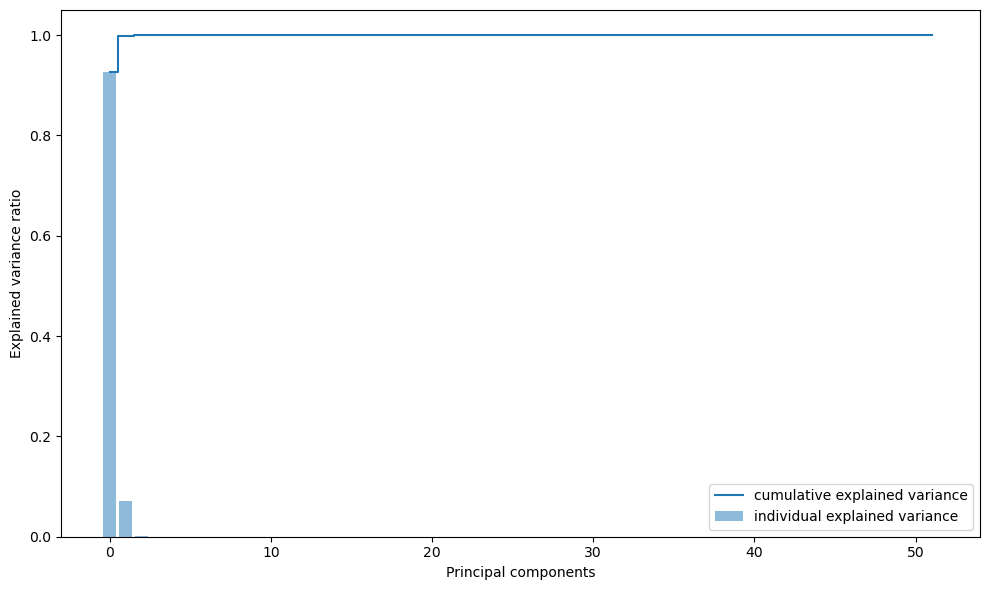

In [125]:
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(cum_explained_var)), cum_explained_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the first principal component explains almost all of the variance. Looking at the coefficients, we can see that 'Duration' is the most important factor by almost two orders of magnitude. As discussed earlier, this isn't really a valid predictor but it is interesting to see just how much it is correlated with subscriptions.

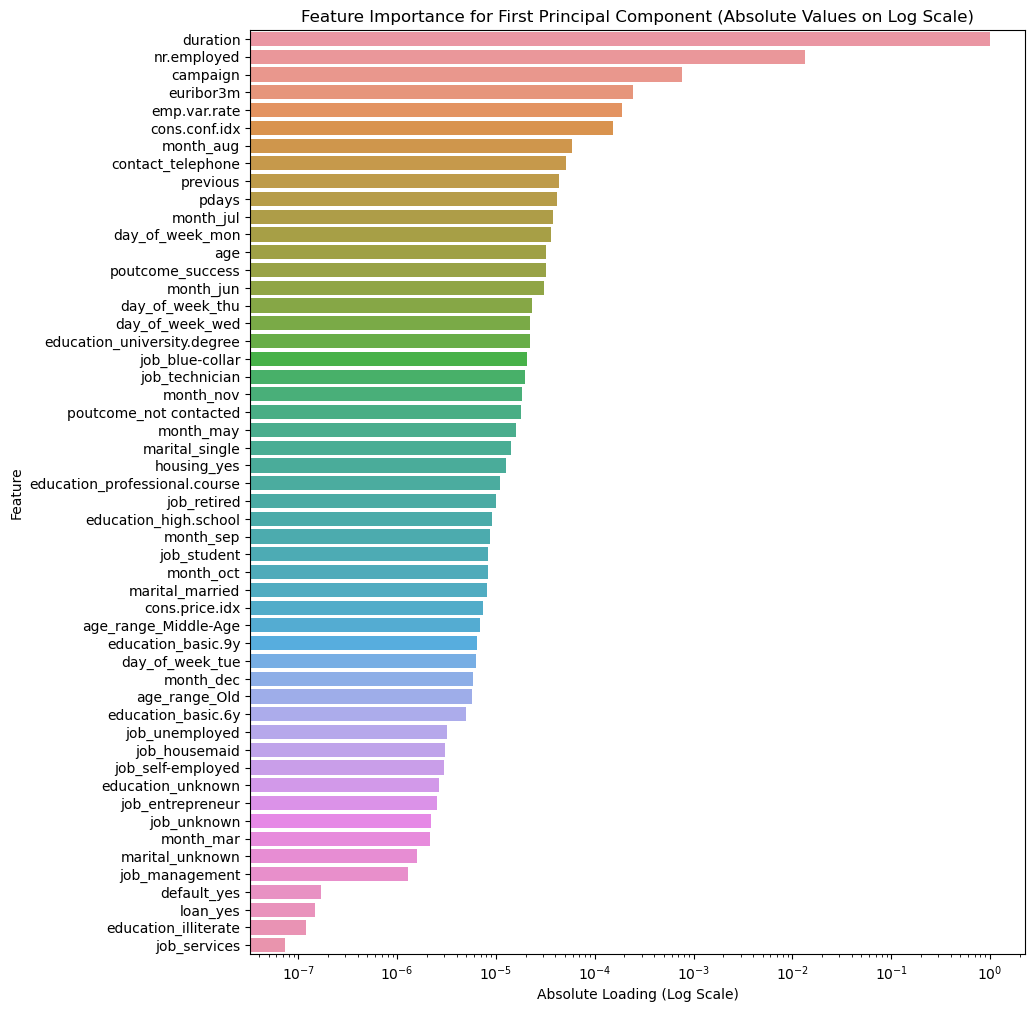

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract weights (loadings) for the first principal component
loadings = pca.components_[0]

# Create a DataFrame for the loadings
feature_names = df_numeric.drop(columns=['y', 'y_num']).columns.tolist()
df_loadings = pd.DataFrame({'feature': feature_names, 'loading': loadings})

# Sort DataFrame by the absolute value of the loading for better visualization
df_loadings['abs_loading'] = df_loadings['loading'].abs()
df_loadings = df_loadings.sort_values(by='abs_loading', ascending=False)

# Create a bar plot with a taller figure
plt.figure(figsize=(10,12))  # Increase the height
ax = sns.barplot(x='abs_loading', y='feature', data=df_loadings)
ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
plt.title('Feature Importance for First Principal Component (Absolute Values on Log Scale)')
plt.xlabel('Absolute Loading (Log Scale)')
plt.ylabel('Feature')
plt.show()

# Extensive help with debugging: GPT-4

The feature loadings of the first principal component are shown on the figure above. They are plotted as absolute values, so they can be regarded as feature importance. The scale is logarithmic, so the difference in feature importance is much larger than it appears. We can see that 'Duration' is by far the most important feature, followed by 'Employment Number (Portugal)' and 'Campaign'. The economic features are all fairly highly ranked, which suggests they are an important predictor of subscription to a term deposit.

## References

@misc{digit-recognizer,
    author = {AstroDave, Will Cukierski},
    title = {Digit Recognizer},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/digit-recognizer}
}

@misc{MNIST,
    author = {Yann, LecCun, Corinna Cortes, Christopher J.C. Burges},
    title = {The MNIST Database of Handwritten Digits},
    publisher = {yan.lecun.com},
    url = {http://yann.lecun.com/exdb/mnist/}
}